In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings("ignore")


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
import contractions
import emoji
from autocorrect import Speller
import textstat


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df = pd.read_csv(r"/content/cleaned_dataset.csv")

# Keep relevant columns and clean
df = df[['statement', 'status']].drop_duplicates(subset='statement')
df = df[df['status'].notnull()].reset_index(drop=True)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89841 entries, 0 to 89840
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  89840 non-null  object
 1   status     89841 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB
None


In [5]:


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gensim.downloader as api
import pickle
import logging
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, GaussianNoise, Lambda, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Logging suppression for gensim
logging.getLogger('gensim').setLevel(logging.ERROR)
logging.getLogger('urllib3').setLevel(logging.ERROR)


In [6]:
import pandas as pd

df.dropna(inplace=True)


X_text = df['statement']
y_labels = df['status']
df[['statement', 'status']].head(5)

,statement,status
0,but then i could not think directly now i rece...,Stress
1,is there any way to sleep better i can not sle...,Anxiety
2,always really hyperactive when panic let me sa...,Bipolar
3,doe anyone ever feel like they think of suicid...,Depression
4,i have been always told that i a burden a wast...,Stress


In [7]:


import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    LayerNormalization, GaussianNoise, SpatialDropout1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from tqdm import tqdm
import gensim.downloader as api

# -------------------------------
# 1. Label Encoding
# -------------------------------
label_enc = LabelEncoder()
y_int = label_enc.fit_transform(y_labels)   # y_labels must be provided
y_cat = to_categorical(y_int)
num_classes = y_cat.shape[1]

# -------------------------------
# 2. Tokenization & Padding
# -------------------------------
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)   # X_text must be provided
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# -------------------------------
# 3. Load Word2Vec Google News 300D (or fallback)
# -------------------------------
print("Loading Word2Vec model (this may take a while)...")
word2vec = api.load("word2vec-google-news-300")
print("Word2Vec loaded.")

embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tqdm(word_index.items(), desc="Creating embedding matrix"):
    if i >= num_words:
        continue
    try:
        embedding_matrix[i] = word2vec[word]
    except KeyError:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# -------------------------------
# 4. (Optional) Small Augmentation Layer
# -------------------------------
class AugmentNoiseAndScale(tf.keras.layers.Layer):
    def call(self, x, training=None):
        if training:
            noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01)
            scale = tf.random.uniform([tf.shape(x)[0], 1, 1], minval=0.95, maxval=1.05)
            return (x + noise) * scale
        return x

# -------------------------------
# 5. Simple Model Architecture (ONE BiLSTM, NO Attention)
# -------------------------------
lstm_units = 64

input_layer = Input(shape=(max_len,), name="input")

x = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True
)(input_layer)

x = SpatialDropout1D(0.3)(x)
x = GaussianNoise(0.1)(x)
x = AugmentNoiseAndScale()(x)

x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.4)(x)
x = LayerNormalization()(x)

output = Dense(num_classes, activation="softmax", name="output")(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()

# -------------------------------
# 6. Compile
# -------------------------------
loss_fn = CategoricalCrossentropy(label_smoothing=0.05)
optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-4, clipnorm=1.0)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# -------------------------------
# 7. Callbacks
# -------------------------------
callbacks = [
    ModelCheckpoint("best_simple_rnn.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1)
]

# -------------------------------
# 8. Train/Test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# -------------------------------
# 9. Train
# -------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Loading Word2Vec model (this may take a while)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec loaded.


Creating embedding matrix: 100%|██████████| 73713/73713 [00:00<00:00, 747309.71it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 100, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment_noise_and_scale         │ (None, 100, 300)       │             0 │
│ (AugmentNoiseAndScale)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,204,807 (12.23 MB)

 Trainable params: 3,204,807 (12.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1121/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2650 - loss: 1.9707
Epoch 1: val_loss improved from inf to 1.35142, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - accuracy: 0.2652 - loss: 1.9701 - val_accuracy: 0.5378 - val_loss: 1.3514 - learning_rate: 3.0000e-04
Epoch 2/10
1122/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5286 - loss: 1.3368
Epoch 2: val_loss improved from 1.35142 to 1.03778, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 72s 31ms/step - accuracy: 0.5287 - loss: 1.3366 - val_accuracy: 0.6868 - val_loss: 1.0378 - learning_rate: 3.0000e-04
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6739 - loss: 1.0358
Epoch 3: val_loss improved from 1.03778 to 0.94191, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.6739 - loss: 1.0358 - val_accuracy: 0.7365 - val_loss: 0.9419 - learning_rate: 3.0000e-04
Epoch 4/10
1122/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7213 - loss: 0.9154
Epoch 4: val_loss improved from 0.94191 to 0.90283, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.7213 - loss: 0.9154 - val_accuracy: 0.7560 - val_loss: 0.9028 - learning_rate: 3.0000e-04
Epoch 5/10
1122/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7600 - loss: 0.8339
Epoch 5: val_loss improved from 0.90283 to 0.85582, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.7600 - loss: 0.8339 - val_accuracy: 0.7882 - val_loss: 0.8558 - learning_rate: 3.0000e-04
Epoch 6/10
1122/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7920 - loss: 0.7713
Epoch 6: val_loss improved from 0.85582 to 0.82899, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.7920 - loss: 0.7713 - val_accuracy: 0.8066 - val_loss: 0.8290 - learning_rate: 3.0000e-04
Epoch 7/10
1121/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8101 - loss: 0.7222
Epoch 7: val_loss improved from 0.82899 to 0.79627, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8101 - loss: 0.7222 - val_accuracy: 0.8146 - val_loss: 0.7963 - learning_rate: 3.0000e-04
Epoch 8/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8281 - loss: 0.6795
Epoch 8: val_loss did not improve from 0.79627
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8281 - loss: 0.6794 - val_accuracy: 0.8217 - val_loss: 0.8095 - learning_rate: 3.0000e-04
Epoch 9/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8442 - loss: 0.6453
Epoch 9: val_loss did not improve from 0.79627
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8442 - loss: 0.6453 - val_accuracy: 0.8295 - val_loss: 0.7996 - learning_rate: 3.0000e-04
Epoch 10/10
1121/1123 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8575 - loss: 0.6143
Epoch 10: val_loss improved from 0.79627 to 0.77784, saving model to best_simple_rnn.h5


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8575 - loss: 0.6143 - val_accuracy: 0.8360 - val_loss: 0.7778 - learning_rate: 3.0000e-04


562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Test Accuracy: 83.60%

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.86      0.91      0.89      2715
             Bipolar       0.90      0.87      0.88      2745
          Depression       0.77      0.52      0.62      2438
              Normal       0.91      0.92      0.91      2906
Personality disorder       0.90      0.94      0.92      2305
              Stress       0.81      0.86      0.84      2573
            Suicidal       0.67      0.81      0.73      2286

            accuracy                           0.84     17968
           macro avg       0.83      0.83      0.83     17968
        weighted avg       0.84      0.84      0.83     17968



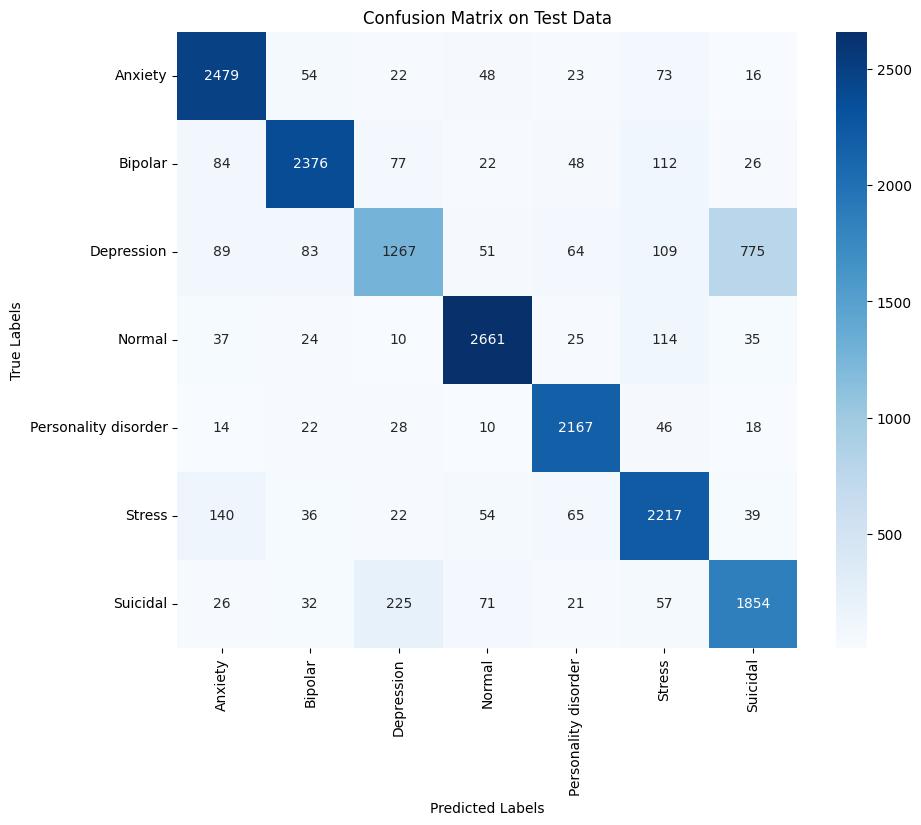

In [8]:
# -------------------------------
# 10. Evaluate Model on Test Data
# -------------------------------
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities
y_pred_probs = model.predict(X_test, verbose=1)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute accuracy
test_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Classification report (precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_enc.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# -------------------------------
# 11. Plot Confusion Matrix
# -------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_enc.classes_,
    yticklabels=label_enc.classes_
)
plt.title("Confusion Matrix on Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [2]:
!pip install gensim nltk pickle-mixin --quiet
!pip install pandas numpy nltk textblob contractions emoji autocorrect textstat matplotlib seaborn wordcloud tensorflow scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.3 MB/s eta 0:00:00
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=549f97ef3b4cdd41b2ce2e6aee6ad7b26bf89dcd7da7048c189ab7c56545b73c
  Stored in directory: /root/.cache/pip/wheels/b6/28/c2/9ddf8f57f871b55b6fd0ab99c887531fb9a66e5ff236b82aee
Successfully built autocorrect
